In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from agae import *
from utils import *
from sklearn.metrics import f1_score

In [3]:

device = get_default_device()
print(torch.__version__)  #注意是双下划线
print(device)

1.13.1+cu117
cuda


### 处理正常数据

In [47]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal.csv", header=0)#, nrows=1000)
print(normal.head())
print(normal.columns)

                Timestamp    FIT101    LIT101  MV101  P101  P102    AIT201  \
0   22/12/2015 4:00:00 PM  2.470294  261.5804      2     2     1  244.3284   
1   22/12/2015 4:00:01 PM  2.457163  261.1879      2     2     1  244.3284   
2   22/12/2015 4:00:02 PM  2.439548  260.9131      2     2     1  244.3284   
3   22/12/2015 4:00:03 PM  2.428338  260.2850      2     2     1  244.3284   
4   22/12/2015 4:00:04 PM  2.424815  259.8925      2     2     1  244.4245   

    AIT202   AIT203    FIT201  ...  P501  P502    PIT501  PIT502    PIT503  \
0  8.19008  306.101  2.471278  ...     1     1  10.02948     0.0  4.277749   
1  8.19008  306.101  2.468587  ...     1     1  10.02948     0.0  4.277749   
2  8.19008  306.101  2.467305  ...     1     1  10.02948     0.0  4.277749   
3  8.19008  306.101  2.466536  ...     1     1  10.02948     0.0  4.277749   
4  8.19008  306.101  2.466536  ...     1     1  10.02948     0.0  4.277749   

     FIT601  P601  P602  P603  Normal/Attack  
0  0.000256    

In [48]:
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape
print(normal.head())

     FIT101    LIT101  MV101  P101  P102    AIT201   AIT202   AIT203  \
0  2.470294  261.5804      2     2     1  244.3284  8.19008  306.101   
1  2.457163  261.1879      2     2     1  244.3284  8.19008  306.101   
2  2.439548  260.9131      2     2     1  244.3284  8.19008  306.101   
3  2.428338  260.2850      2     2     1  244.3284  8.19008  306.101   
4  2.424815  259.8925      2     2     1  244.4245  8.19008  306.101   

     FIT201  MV201  ...  FIT504  P501  P502    PIT501  PIT502    PIT503  \
0  2.471278      2  ...     0.0     1     1  10.02948     0.0  4.277749   
1  2.468587      2  ...     0.0     1     1  10.02948     0.0  4.277749   
2  2.467305      2  ...     0.0     1     1  10.02948     0.0  4.277749   
3  2.466536      2  ...     0.0     1     1  10.02948     0.0  4.277749   
4  2.466536      2  ...     0.0     1     1  10.02948     0.0  4.277749   

     FIT601  P601  P602  P603  
0  0.000256     1     1     1  
1  0.000256     1     1     1  
2  0.000256     1   

In [49]:
# Transform all columns into float64
normal = normal.astype(float)

In [50]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [56]:
normal.head(2)


[0.2729987  0.27286366 0.27275194 0.27265169 0.27268711 0.27280936
 0.27314225 0.27346321 0.27378629 0.27421398 0.2744493  0.27460317
 0.27472154 0.27468265 0.27472021 0.27466063 0.27464239 0.27457431
 0.27448425 0.27438619 0.2745659  0.27451356 0.27436974 0.27429671
 0.27421838 0.27407674 0.27381944 0.27369325 0.27360629 0.27359413
 0.27366237 0.27408204 0.27445094 0.27471766 0.27500627 0.27526988
 0.27536806 0.27551966 0.27558808 0.27544093 0.27550588 0.27557284
 0.27555357 0.27544743 0.27533651 0.27541535 0.27534096 0.27524429
 0.27517177 0.27504513 0.27496534 0.27502209 0.27502209 0.27475794
 0.27465357 0.27466789 0.27463906 0.27460082 0.27498497 0.27530083
 0.27530083 0.27562008 0.27598981 0.27645329 0.27674485 0.27681039
 0.27679953 0.27659583 0.27661636 0.276644   0.27665845 0.27655593
 0.27643331 0.276273   0.27626358 0.27616246 0.27609264 0.27610508
 0.27609592 0.27597123 0.27588522 0.27597073 0.2761077  0.27611228
 0.27631458 0.27675998 0.27701333 0.27732853 0.27757613 0.2777

### 处理攻击数据

In [26]:
#Read data
#attack = pd.read_csv("input/SWaT_Dataset_Attack.csv",header=0)#, nrows=1000)
attack = pd.read_csv("C:\\Users\\helloworld\\Desktop\\swat\\sample.csv",header=0)#, nrows=1000)
print(normal.columns)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values] #等于normal就是0，异常就是1
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
print("测试数据集形状：{}，标签长度：{}".format(attack.shape, len(labels)))

RangeIndex(start=0, stop=51, step=1)
测试数据集形状：(233, 51)，标签长度：233


In [27]:
# Transform all columns into float64
attack = attack.astype(float)
x2 = attack.values
x_scaled2 = min_max_scaler.fit_transform(x2)
attack = pd.DataFrame(x_scaled2)

In [28]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.226206,0.242423,0.0,0.0,0.0,0.0,0.571444,1.0,0.379994,0.0,...,0.421051,0.0,0.0,0.285743,0.473686,0.454607,0.0,0.0,0.0,0.0
1,0.226206,0.242423,0.0,0.0,0.0,0.0,0.571444,1.0,0.379994,0.0,...,0.421051,0.0,0.0,0.285743,0.473686,0.454607,0.0,0.0,0.0,0.0


In [29]:
print(normal.shape)
window_size = 12
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]] #窗口化处理
windows_normal.shape

(496800, 51)


(496788, 12, 51)

In [30]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(221, 12, 51)

In [31]:
## Training

In [32]:
import torch.utils.data as data_utils

BATCH_SIZE =  7000
N_EPOCHS = 100
hidden_size = 200

In [33]:
w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=hidden_size
windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]
print("输入层维度：{}， 潜空间维度：{}，训练数据集：{}，验证数据集：{}".format(w_size, z_size, windows_normal_train.shape, windows_normal_val.shape))

输入层维度：612， 潜空间维度：200，训练数据集：(397430, 12, 51)，验证数据集：(99358, 12, 51)


In [34]:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
model = AGAEModel(w_size, z_size)
model = to_device(model,device)

In [43]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], 训练耗时：4.29s, val_loss1: 0.0249, val_loss2: 0.0248
Epoch [1], 训练耗时：3.75s, val_loss1: 0.0266, val_loss2: -0.0030
Epoch [2], 训练耗时：4.11s, val_loss1: 0.0268, val_loss2: -0.0111
Epoch [3], 训练耗时：3.97s, val_loss1: 0.0274, val_loss2: -0.0156
Epoch [4], 训练耗时：3.95s, val_loss1: 0.0277, val_loss2: -0.0181
Epoch [5], 训练耗时：3.87s, val_loss1: 0.0280, val_loss2: -0.0200
Epoch [6], 训练耗时：3.84s, val_loss1: 0.0288, val_loss2: -0.0217
Epoch [7], 训练耗时：4.13s, val_loss1: 0.0295, val_loss2: -0.0232
Epoch [8], 训练耗时：4.07s, val_loss1: 0.0289, val_loss2: -0.0234
Epoch [9], 训练耗时：3.94s, val_loss1: 0.0289, val_loss2: -0.0240
Epoch [10], 训练耗时：4.41s, val_loss1: 0.0300, val_loss2: -0.0254
Epoch [11], 训练耗时：4.10s, val_loss1: 0.0293, val_loss2: -0.0251
Epoch [12], 训练耗时：3.80s, val_loss1: 0.0292, val_loss2: -0.0253
Epoch [13], 训练耗时：4.04s, val_loss1: 0.0298, val_loss2: -0.0261
Epoch [14], 训练耗时：4.14s, val_loss1: 0.0291, val_loss2: -0.0257
Epoch [15], 训练耗时：3.91s, val_loss1: 0.0299, val_loss2: -0.0267
Epoch [16], 训练耗时：3.

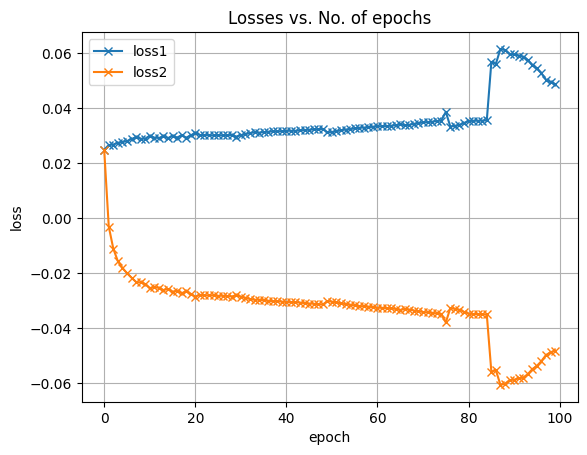

In [46]:
plot_history(history)

In [47]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [35]:
checkpoint = torch.load("model.pth")
model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [19]:
ts=testing(model,val_loader)
tp=np.concatenate([torch.stack(ts[:-1]).flatten().detach().cpu().numpy(),
                              ts[-1].flatten().detach().cpu().numpy()])
maxT=np.max(tp)
minT=np.min(tp)
print("最大阈值：{}，最小阈值：{}".format(maxT,minT))

最大阈值：0.02420607954263687，最小阈值：-0.14347247779369354


In [45]:
#测试集测试，并展开成数组
results=testing(model,train_loader)
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),results[-1].flatten().detach().cpu().numpy()])
#y_pred=torch.stack(results[:]).flatten().detach().cpu().numpy()
print(y_pred[:221])

[-0.26242232 -0.2622805  -0.26213092 -0.26196876 -0.2618033  -0.26164228
 -0.26149696 -0.26138645 -0.26131022 -0.26124528 -0.2612198  -0.26122552
 -0.26124984 -0.26129082 -0.26134023 -0.2614137  -0.2614925  -0.261577
 -0.2616569  -0.26172376 -0.2617479  -0.26175702 -0.2617401  -0.2616877
 -0.26160762 -0.26151264 -0.26139355 -0.2612481  -0.26110452 -0.26094815
 -0.26078558 -0.26063022 -0.26051816 -0.2604455  -0.26038805 -0.2603603
 -0.2603622  -0.26037827 -0.26041707 -0.26046795 -0.26050165 -0.2605409
 -0.260607   -0.26067993 -0.26074284 -0.2607989  -0.2608647  -0.2608933
 -0.2608881  -0.2608769  -0.2608293  -0.26074475 -0.26062706 -0.26048535
 -0.26031637 -0.26013947 -0.25998056 -0.2598185  -0.25965098 -0.2595133
 -0.2594099  -0.25931597 -0.25926146 -0.2592382  -0.25926203 -0.25931555
 -0.25937334 -0.2594312  -0.25948274 -0.25954247 -0.25959742 -0.2596421
 -0.25967824 -0.2596884  -0.25964913 -0.2595882  -0.25949258 -0.2593709
 -0.25923884 -0.25910598 -0.25895107 -0.2587888  -0.2586405 

In [21]:
for i in range(len(y_pred)):
    y_pred[i] = 1 if (y_pred[i] > maxT or y_pred[i] < minT) else 0
print(sum(y_pred))

41000.0


In [39]:
#标签窗口化
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))
#以窗口为单位设置异常
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]
print(sum(y_test))
print(len(y_test))

221.0
221


In [40]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [41]:
threshold=ROC(y_test, y_pred)

D:\environment\miniconda\envs\pytorch-gpu\lib\site-packages\sklearn\metrics\_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.